In [1]:
import numpy as np
import torch as pt
from matplotlib import pyplot as plt
import sys
from pathlib import Path
import src.constants as constants
import sys
from display_data.data_acquisition_shadow import derandomized_classical_shadow, randomized_classical_shadow
from display_data.prediction_shadow import estimate_exp
sys.path.append(Path('../src'))
from src.mps import MPS
from src.tfim_hamiltonian_open_fermion import TfimHamiltonianOpenFermion
from src.mps_quantum_state import MPSQuantumState

In [2]:
#generate a random tensor list
qubit_num = 10
bond_dim = 50
tensor_liste = [pt.randn([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))

In [2]:
# this function converts the stored measurement outcomes to the correct shape needed for the shadow prediction
def conversion_to_prediction_shadow_dict_shape(measurement_procedure, measurement_index, qubit_num):
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(qubit_num))
    strs = to_str_func(measurement_index)
    dirac_rep = np.zeros(list(measurement_index.shape) + [qubit_num], dtype=np.int8)
    for bit_ix in range(0, qubit_num):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        dirac_rep[...,bit_ix] = fetch_bit_func(strs).astype("int8")
    measurement_array = np.where(dirac_rep == 1, -1, dirac_rep)
    measurement_array = np.where(dirac_rep == 0, 1, measurement_array)
    measurement = np.dstack((measurement_procedure, np.array(measurement_array, dtype=int)))
    return measurement

In [15]:
ratio_h_j = 0.1
qubit_num = 6
save_direc_groundstate = Path('data/Diagonal_hamiltonian/groundstate_dict.npy')
ground_state_dict = np.load(save_direc_groundstate, allow_pickle='TRUE')
ground_state_dict = ground_state_dict.item()
ground_state = ground_state_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)]
mps = MPS.from_state_vector(qubit_num, ground_state)

In [16]:
save_direc_eigs = Path('data/Diagonal_hamiltonian/eigenvalues_first_three_dict.npy')
energy_dict = np.load(save_direc_eigs, allow_pickle=True)
energy_dict = energy_dict.item()
energy_brute = energy_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)][0]
print(energy_brute)

-5.020016662087988


In [17]:
# now we have a method to keep only the unique indices, now we convert the measurements to the necessary shape for shadow prediction
batches = 10
num_of_measurements = np.array([10, 20, 50, 100, 200, 500, 1000])
num_of_measurements_per_rot = 200
energies_different_meas_num = np.zeros((np.size(num_of_measurements), batches))
mps.normalise()
mps.canonicalise(qubit_num - 1)
for b in range(batches):
    print('starting batch ' + str(b))
    for i in range(np.size(num_of_measurements)):
        meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(num_of_measurements[i], num_of_measurements_per_rot)
        energies = pt.zeros(len(meas_outcomes))
        for n in range(len(meas_outcomes)):
            probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(meas_outcomes[n]))
            measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(meas_outcomes[n]), np.array(meas_outcomes[n]), qubit_num)
            energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_direct)
        energy = pt.mean(energies)
        energies_different_meas_num[i,b] = energy

starting batch 0
starting batch 1
starting batch 2
starting batch 3
starting batch 4
starting batch 5
starting batch 6
starting batch 7
starting batch 8
starting batch 9


Text(0, 0.5, '$\\epsilon$')

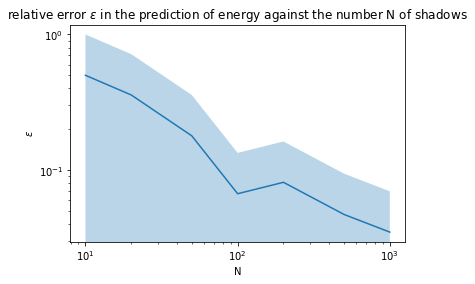

In [18]:
rel_error = np.abs((energies_different_meas_num - energy_brute) / energy_brute)
rel_error_mean = np.mean(rel_error, axis=1)
rel_error_std = np.mean(rel_error, axis=1)
plt.plot(num_of_measurements, rel_error_mean)
plt.fill_between(num_of_measurements, rel_error_mean - rel_error_std, rel_error_mean + rel_error_std, alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.title('relative error $\epsilon$ in the prediction of energy against the number N of shadows')
plt.xlabel('N')
plt.ylabel('$\epsilon$')

In [28]:
# now we try to estimate the gradient directly by contracting the mps with hamiltonian
#generate a random tensor list
qubit_num = 6
ratio_h_j = 0.1
bond_dim = 50
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand).normalise()
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [20]:
# we estimate the energy exactly by contraction with the hamiltonian
random_param_vec_brute = random_param_vec.detach()
random_param_vec_brute.requires_grad_(True)
mps.from_param_vec(param_vec=random_param_vec_brute)
psi = mps.to_state_vector()
hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
energy_bf = psi.conj() @ hamiltonian @ psi / (psi.conj() @ psi)
print(f'BF E = {energy_bf}')
energy_bf.backward()

BF E = (0.5958803834905864+0j)


In [21]:
# now we estimate the gradient by using the classical shadows
num_of_measurements = np.array([10, 20, 50, 100, 200, 500])
num_of_measurements_per_rot = 200
batches = 5
errors = np.zeros((np.size(num_of_measurements), batches))

for b in range(0, batches):
    for j in range(np.size(num_of_measurements)):
        random_param_vec_shadow = random_param_vec.detach()
        random_param_vec_shadow.requires_grad_(True)
        mps = MPS.from_tensor_list(tensor_liste_rand)
        mps.from_param_vec(param_vec=random_param_vec_shadow)
        mps.normalise()
    #mps.tensors[0] = mps.tensors[0] / mps.norm()
        meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(num_of_measurements[j], num_of_measurements_per_rot)
        energies = pt.zeros(len(meas_outcomes))
        for n in range(len(meas_outcomes)):
            probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(meas_outcomes[n]))
            measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(meas_outcomes[n]), np.array(meas_outcomes[n]), qubit_num)
            energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_direct)
        energy_shadow = pt.mean(energies)
        print(f'SH E = {energy_shadow}')
        energy_shadow.backward()
        errors[j,b] = pt.linalg.norm((random_param_vec_brute.grad - random_param_vec_shadow.grad)/pt.linalg.norm(random_param_vec_brute.grad))

SH E = 0.595568835735321
SH E = 0.5090430378913879
SH E = 0.5312356352806091
SH E = 0.586112380027771
SH E = 0.6039906144142151
SH E = 0.5812474489212036
SH E = 0.7198468446731567
SH E = 0.7485888004302979
SH E = 0.6199989914894104
SH E = 0.609914243221283
SH E = 0.6088409423828125
SH E = 0.6096405982971191
SH E = 0.6562424302101135
SH E = 0.4891132414340973
SH E = 0.6034649014472961
SH E = 0.6662202477455139
SH E = 0.604587733745575
SH E = 0.6287092566490173
SH E = 0.6680187582969666
SH E = 0.5541718006134033
SH E = 0.624954342842102
SH E = 0.6692126393318176
SH E = 0.5808590054512024
SH E = 0.6157920360565186
SH E = 0.5356894731521606
SH E = 0.647311806678772
SH E = 0.6327542662620544
SH E = 0.5311230421066284
SH E = 0.5685957074165344
SH E = 0.5744816660881042


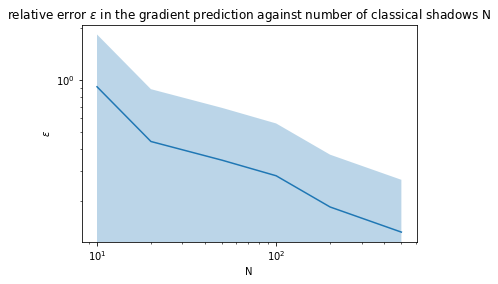

In [22]:
rel_error_mean = np.mean(errors, axis=1)
rel_error_std = np.mean(errors, axis=1)
plt.plot(num_of_measurements, rel_error_mean)
plt.fill_between(num_of_measurements, rel_error_mean - rel_error_std, rel_error_mean + rel_error_std, alpha=0.3)
plt.title('relative error $\epsilon$ in the gradient prediction against number of classical shadows N')
plt.xlabel('N')
plt.ylabel('$\epsilon$')
plt.yscale('log')
plt.xscale('log')

In [ ]:
# we do gradient descent with the exact hamiltonian contraction method and see whether we converge to the ground state

In [23]:
# doing gradient descent using pytorch optimizer
step_num = 500
lr = 0.01
random_param_vec_brute = random_param_vec.detach()
random_param_vec_brute.requires_grad_(True)
opt = pt.optim.Adam([random_param_vec_brute], lr=lr)

accuracy = np.zeros(step_num)
for i in range(0, step_num):
    opt.zero_grad()
    mps.from_param_vec(param_vec = random_param_vec_brute)
    psi = mps.to_state_vector()
    hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
    energy = psi.conj() @ hamiltonian @ psi / (psi.conj() @ psi)
    energy.backward()
    accuracy[i] = np.abs(energy.detach() - energy_brute) / np.abs(energy_brute)
    opt.step()

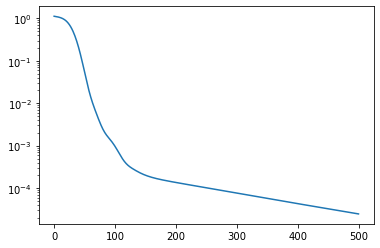

In [24]:
plt.plot(np.arange(0, step_num), accuracy)
plt.yscale('log')

In [34]:
# now we try to estimate the gradient directly by contracting the mps with hamiltonian
#generate a random tensor list
qubit_num = 6
ratio_h_j = 0.1
bond_dim = 50
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand).normalise()
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [ ]:
# doing gradient descent using pytorch optimizer
step_num = 20
lr = 0.1
random_param_vec_shadow = random_param_vec.detach()
random_param_vec_shadow.requires_grad_(True)
opt = pt.optim.Adam([random_param_vec_shadow])
num_of_measurements = 100
num_of_measurements_per_rot = 1000

accuracy = np.zeros(step_num)
for i in range(step_num):
    opt.zero_grad()
    mps.from_param_vec(param_vec=random_param_vec_shadow)
    mps.normalise()
    with pt.no_grad():
        meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(num_of_measurements, num_of_measurements_per_rot)
    energies = pt.zeros(len(meas_outcomes))
    for n in range(len(meas_outcomes)):
        probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(meas_outcomes[n]))
        measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(meas_outcomes[n]), np.array(meas_outcomes[n]), qubit_num)
        energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_direct)
    energy_shadow = pt.mean(energies)
    energy_shadow.backward()
    accuracy[i] = np.abs(energy_shadow.detach() - energy_brute) / np.abs(energy_brute)
    opt.step()
    print('progress: ' + str(i+1) + ' / ' + str(step_num))
    print(f'SH E = {energy_shadow}')
    print(f'loss = {accuracy[i]}')

In [ ]:
plt.plot(np.arange(0, step_num), accuracy)
plt.title('relative error $\epsilon$ in the prediction of the ground state against number of iterations')
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('$\epsilon$')

In [22]:
%timeit MPSQuantumState(qubit_num, mps).amplitude(pt.tensor([0]))

3 ms ± 577 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
